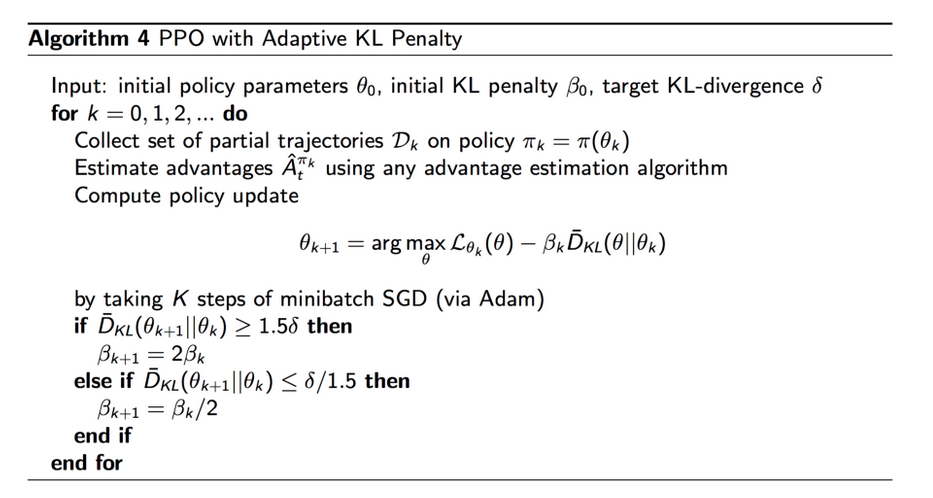

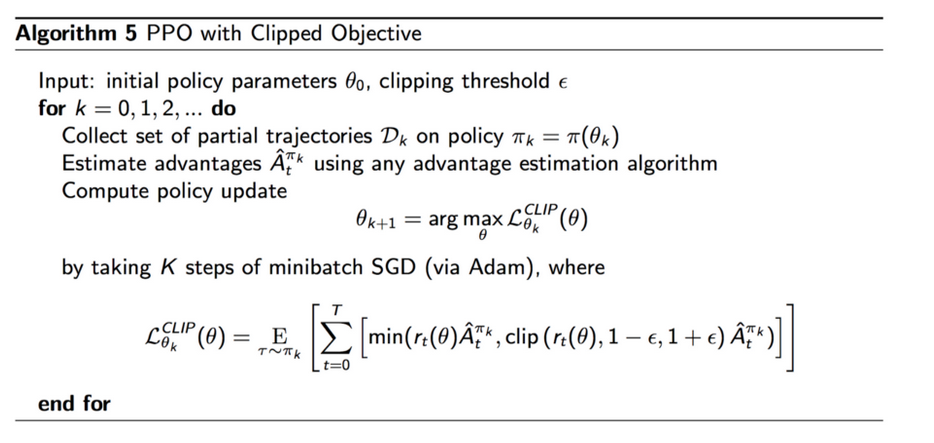

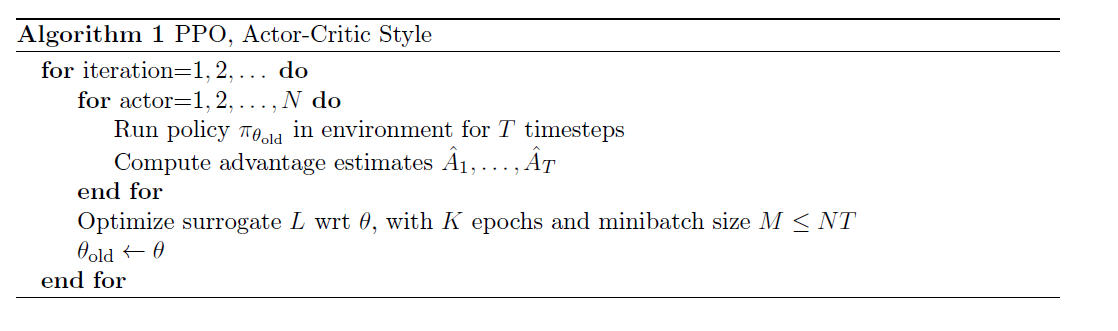

Based on the literature we will implement the best performance algo which is the clipped objective version

Reference: https://colab.research.google.com/github/nikhilbarhate99/PPO-PyTorch/blob/master/PPO_colab.ipynb#scrollTo=j5Rx_IFKHK-D

In [3]:
import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import numpy as np
import pandas as pd

import gym
from machine import Machine
from GymMachEnv import MachineEnv
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [4]:
def tensorboard_func(array,name):
    writer = SummaryWriter(name)
    
    for x in array:
        writer.add_scalar('log/Average_score', x[0], x[1])
        

class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space


        self.actor = nn.Sequential(
                            nn.Linear(state_dim,128),
                            nn.ReLU(),
                            nn.Linear(128,64),
                            nn.ReLU(),
                            nn.Linear(64,action_dim),
                            
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                            nn.Linear(state_dim,128),
                            nn.ReLU(),
                            nn.Linear(128,64),
                            nn.ReLU(),
                            nn.Linear(64,1)
                    )
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError
    

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.detach(), action_logprob.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()



    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state)
                action, action_logprob = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()


    def update(self,writer):
        global count
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7) #normalised rewards

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach()
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach()
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach()

        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            writer.add_scalar('loss',loss.mean(),count)
            count+=1
            #print(count)
            
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        
        
       

In [5]:
###################################Initialise Env###########################
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [6]:

################ PPO hyperparameters ################
has_continuous_action_space = False
max_ep_len = 100                    # max timesteps in one episode
max_training_timesteps = int(5e5)   # break training loop if timeteps > max_training_timesteps
update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 2e-02              # clip parameter for PPO
gamma = 0.95                # discount factor
action_std = None

lr_actor = 1e-04       # learning rate for actor network
lr_critic = 1e-03       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)


print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(2e4)      # save model frequency (in num timesteps)
max_episodes = 40000
count = 0
#####################################################

In [7]:
# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, False, action_std)

In [8]:

writer = SummaryWriter("PPO_GMM_tensorboard/PPO_best_new")

# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")

# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0

tracker = []

print_freq_ep = 20

#checkpoint_path = 'default_ppo_agent.pt'

# training loop
while i_episode <= max_episodes:
    
    state = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):
        
        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward

        #update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update(writer)

            
        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            #print("saving model at : " + checkpoint_path)
            #ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")
            
        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    i_episode += 1
    
    # printing average reward
    if i_episode % print_freq_ep == 0:

        # print average reward till last episode
        print_avg_reward = print_running_reward / print_running_episodes
        print_avg_reward = round(print_avg_reward, 2)
        tracker.append([i_episode,print_avg_reward])
        print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))
        writer.add_scalar('Rewards',print_avg_reward,i_episode)
        
        print_running_reward = 0
        print_running_episodes = 0

env.close()




# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")

Started training at (GMT) :  2022-03-02 20:30:37
Episode : 20 		 Timestep : 1046 		 Average Reward : 22025.0
Episode : 40 		 Timestep : 2147 		 Average Reward : 23955.0
Episode : 60 		 Timestep : 3188 		 Average Reward : 19865.0
Episode : 80 		 Timestep : 3885 		 Average Reward : 13535.0
Episode : 100 		 Timestep : 4717 		 Average Reward : 17690.0
Episode : 120 		 Timestep : 5831 		 Average Reward : 24640.0
Episode : 140 		 Timestep : 6899 		 Average Reward : 24885.0
Episode : 160 		 Timestep : 7697 		 Average Reward : 19335.0
Episode : 180 		 Timestep : 8615 		 Average Reward : 23585.0
Episode : 200 		 Timestep : 9980 		 Average Reward : 34250.0
Episode : 220 		 Timestep : 10861 		 Average Reward : 21090.0
Episode : 240 		 Timestep : 11610 		 Average Reward : 17815.0
Episode : 260 		 Timestep : 12564 		 Average Reward : 23835.0
Episode : 280 		 Timestep : 13237 		 Average Reward : 15240.0
Episode : 300 		 Timestep : 14158 		 Average Reward : 21510.0
Episode : 320 		 Timestep : 14871 	

Episode : 2320 		 Timestep : 96692 		 Average Reward : 21330.0
Episode : 2340 		 Timestep : 97443 		 Average Reward : 18380.0
Episode : 2360 		 Timestep : 98520 		 Average Reward : 28480.0
Episode : 2380 		 Timestep : 99561 		 Average Reward : 28345.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  0:04:34
--------------------------------------------------------------------------------------------
Episode : 2400 		 Timestep : 100366 		 Average Reward : 20640.0
Episode : 2420 		 Timestep : 101258 		 Average Reward : 22885.0
Episode : 2440 		 Timestep : 102218 		 Average Reward : 24490.0
Episode : 2460 		 Timestep : 103237 		 Average Reward : 26635.0
Episode : 2480 		 Timestep : 104078 		 Average Reward : 20505.0
Episode : 2500 		 Timestep : 104693 		 Average Reward : 15825.0
Episode : 2520 		 Timestep : 105627 		 Average Reward : 23285.0
Episode : 2540 		 Timestep : 106522 		 Average Reward : 21865.0
Episode : 256

Episode : 4540 		 Timestep : 197200 		 Average Reward : 22495.0
Episode : 4560 		 Timestep : 197928 		 Average Reward : 18995.0
Episode : 4580 		 Timestep : 199221 		 Average Reward : 35540.0
Episode : 4600 		 Timestep : 199914 		 Average Reward : 18645.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  0:08:58
--------------------------------------------------------------------------------------------
Episode : 4620 		 Timestep : 200886 		 Average Reward : 26515.0
Episode : 4640 		 Timestep : 201445 		 Average Reward : 14510.0
Episode : 4660 		 Timestep : 202308 		 Average Reward : 21870.0
Episode : 4680 		 Timestep : 203260 		 Average Reward : 25885.0
Episode : 4700 		 Timestep : 204310 		 Average Reward : 29045.0
Episode : 4720 		 Timestep : 205181 		 Average Reward : 24190.0
Episode : 4740 		 Timestep : 205922 		 Average Reward : 18555.0
Episode : 4760 		 Timestep : 207136 		 Average Reward : 32570.0
Episode :

Episode : 6760 		 Timestep : 293778 		 Average Reward : 26975.0
Episode : 6780 		 Timestep : 294884 		 Average Reward : 30810.0
Episode : 6800 		 Timestep : 295654 		 Average Reward : 21140.0
Episode : 6820 		 Timestep : 296748 		 Average Reward : 29870.0
Episode : 6840 		 Timestep : 297618 		 Average Reward : 24310.0
Episode : 6860 		 Timestep : 298601 		 Average Reward : 26605.0
Episode : 6880 		 Timestep : 299378 		 Average Reward : 21000.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  0:13:56
--------------------------------------------------------------------------------------------
Episode : 6900 		 Timestep : 300200 		 Average Reward : 20810.0
Episode : 6920 		 Timestep : 301167 		 Average Reward : 26230.0
Episode : 6940 		 Timestep : 302169 		 Average Reward : 26905.0
Episode : 6960 		 Timestep : 303051 		 Average Reward : 23035.0
Episode : 6980 		 Timestep : 303864 		 Average Reward : 21920.0
Episode :

Episode : 8980 		 Timestep : 397269 		 Average Reward : 22640.0
Episode : 9000 		 Timestep : 398106 		 Average Reward : 21805.0
Episode : 9020 		 Timestep : 399020 		 Average Reward : 24315.0
Episode : 9040 		 Timestep : 399816 		 Average Reward : 21035.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  0:18:51
--------------------------------------------------------------------------------------------
Episode : 9060 		 Timestep : 400734 		 Average Reward : 25220.0
Episode : 9080 		 Timestep : 401549 		 Average Reward : 21705.0
Episode : 9100 		 Timestep : 402475 		 Average Reward : 26190.0
Episode : 9120 		 Timestep : 403546 		 Average Reward : 28810.0
Episode : 9140 		 Timestep : 404385 		 Average Reward : 21720.0
Episode : 9160 		 Timestep : 405311 		 Average Reward : 24330.0
Episode : 9180 		 Timestep : 406359 		 Average Reward : 29285.0
Episode : 9200 		 Timestep : 407334 		 Average Reward : 24890.0
Episode :

Episode : 11180 		 Timestep : 497012 		 Average Reward : 31880.0
Episode : 11200 		 Timestep : 497632 		 Average Reward : 17395.0
Episode : 11220 		 Timestep : 498661 		 Average Reward : 28700.0
Episode : 11240 		 Timestep : 499663 		 Average Reward : 27020.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  0:23:54
--------------------------------------------------------------------------------------------
Episode : 11260 		 Timestep : 500546 		 Average Reward : 25640.0
Episode : 11280 		 Timestep : 501592 		 Average Reward : 30810.0
Episode : 11300 		 Timestep : 502467 		 Average Reward : 23805.0
Episode : 11320 		 Timestep : 503549 		 Average Reward : 29855.0
Episode : 11340 		 Timestep : 504373 		 Average Reward : 21760.0
Episode : 11360 		 Timestep : 505268 		 Average Reward : 24000.0
Episode : 11380 		 Timestep : 506227 		 Average Reward : 26525.0
Episode : 11400 		 Timestep : 507307 		 Average Reward : 30155

Episode : 13360 		 Timestep : 598076 		 Average Reward : 24820.0
Episode : 13380 		 Timestep : 598977 		 Average Reward : 25860.0
Episode : 13400 		 Timestep : 599856 		 Average Reward : 23220.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  0:28:26
--------------------------------------------------------------------------------------------
Episode : 13420 		 Timestep : 600672 		 Average Reward : 22165.0
Episode : 13440 		 Timestep : 601325 		 Average Reward : 17570.0
Episode : 13460 		 Timestep : 602150 		 Average Reward : 22830.0
Episode : 13480 		 Timestep : 603321 		 Average Reward : 32410.0
Episode : 13500 		 Timestep : 604089 		 Average Reward : 20640.0
Episode : 13520 		 Timestep : 605172 		 Average Reward : 30285.0
Episode : 13540 		 Timestep : 606052 		 Average Reward : 23735.0
Episode : 13560 		 Timestep : 606869 		 Average Reward : 22735.0
Episode : 13580 		 Timestep : 607826 		 Average Reward : 25610

Episode : 15540 		 Timestep : 696248 		 Average Reward : 28020.0
Episode : 15560 		 Timestep : 697246 		 Average Reward : 26850.0
Episode : 15580 		 Timestep : 698058 		 Average Reward : 23365.0
Episode : 15600 		 Timestep : 698997 		 Average Reward : 26025.0
Episode : 15620 		 Timestep : 699692 		 Average Reward : 19280.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  0:32:59
--------------------------------------------------------------------------------------------
Episode : 15640 		 Timestep : 700792 		 Average Reward : 30995.0
Episode : 15660 		 Timestep : 701558 		 Average Reward : 21500.0
Episode : 15680 		 Timestep : 702442 		 Average Reward : 23925.0
Episode : 15700 		 Timestep : 703305 		 Average Reward : 22895.0
Episode : 15720 		 Timestep : 704338 		 Average Reward : 28150.0
Episode : 15740 		 Timestep : 705267 		 Average Reward : 25275.0
Episode : 15760 		 Timestep : 706233 		 Average Reward : 25555

Episode : 17720 		 Timestep : 797208 		 Average Reward : 22920.0
Episode : 17740 		 Timestep : 797865 		 Average Reward : 17795.0
Episode : 17760 		 Timestep : 798649 		 Average Reward : 20145.0
Episode : 17780 		 Timestep : 799833 		 Average Reward : 32885.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  0:37:26
--------------------------------------------------------------------------------------------
Episode : 17800 		 Timestep : 800840 		 Average Reward : 28445.0
Episode : 17820 		 Timestep : 801861 		 Average Reward : 30280.0
Episode : 17840 		 Timestep : 802486 		 Average Reward : 16850.0
Episode : 17860 		 Timestep : 803316 		 Average Reward : 23080.0
Episode : 17880 		 Timestep : 804212 		 Average Reward : 24260.0
Episode : 17900 		 Timestep : 804998 		 Average Reward : 22215.0
Episode : 17920 		 Timestep : 805811 		 Average Reward : 21115.0
Episode : 17940 		 Timestep : 806889 		 Average Reward : 29925

Episode : 19900 		 Timestep : 895558 		 Average Reward : 29985.0
Episode : 19920 		 Timestep : 896294 		 Average Reward : 19225.0
Episode : 19940 		 Timestep : 897214 		 Average Reward : 27160.0
Episode : 19960 		 Timestep : 898143 		 Average Reward : 25900.0
Episode : 19980 		 Timestep : 899312 		 Average Reward : 32165.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  0:41:53
--------------------------------------------------------------------------------------------
Episode : 20000 		 Timestep : 900210 		 Average Reward : 23855.0
Episode : 20020 		 Timestep : 901180 		 Average Reward : 25780.0
Episode : 20040 		 Timestep : 902054 		 Average Reward : 24170.0
Episode : 20060 		 Timestep : 902722 		 Average Reward : 17515.0
Episode : 20080 		 Timestep : 903632 		 Average Reward : 25000.0
Episode : 20100 		 Timestep : 904442 		 Average Reward : 22335.0
Episode : 20120 		 Timestep : 905389 		 Average Reward : 28160

Episode : 22080 		 Timestep : 994391 		 Average Reward : 28495.0
Episode : 22100 		 Timestep : 995472 		 Average Reward : 30060.0
Episode : 22120 		 Timestep : 996413 		 Average Reward : 24685.0
Episode : 22140 		 Timestep : 997588 		 Average Reward : 31715.0
Episode : 22160 		 Timestep : 998498 		 Average Reward : 24110.0
Episode : 22180 		 Timestep : 999436 		 Average Reward : 24355.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  0:46:18
--------------------------------------------------------------------------------------------
Episode : 22200 		 Timestep : 1000357 		 Average Reward : 25480.0
Episode : 22220 		 Timestep : 1001273 		 Average Reward : 26190.0
Episode : 22240 		 Timestep : 1002341 		 Average Reward : 29460.0
Episode : 22260 		 Timestep : 1003375 		 Average Reward : 27005.0
Episode : 22280 		 Timestep : 1004177 		 Average Reward : 21865.0
Episode : 22300 		 Timestep : 1005198 		 Average Reward :

Episode : 24240 		 Timestep : 1097006 		 Average Reward : 26650.0
Episode : 24260 		 Timestep : 1097979 		 Average Reward : 27540.0
Episode : 24280 		 Timestep : 1098622 		 Average Reward : 17385.0
Episode : 24300 		 Timestep : 1099602 		 Average Reward : 26920.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  0:50:46
--------------------------------------------------------------------------------------------
Episode : 24320 		 Timestep : 1100833 		 Average Reward : 34825.0
Episode : 24340 		 Timestep : 1101820 		 Average Reward : 26750.0
Episode : 24360 		 Timestep : 1102667 		 Average Reward : 23495.0
Episode : 24380 		 Timestep : 1103382 		 Average Reward : 20180.0
Episode : 24400 		 Timestep : 1104330 		 Average Reward : 25935.0
Episode : 24420 		 Timestep : 1105449 		 Average Reward : 32660.0
Episode : 24440 		 Timestep : 1106328 		 Average Reward : 24575.0
Episode : 24460 		 Timestep : 1107409 		 Average Re

Episode : 26400 		 Timestep : 1197567 		 Average Reward : 26470.0
Episode : 26420 		 Timestep : 1198384 		 Average Reward : 22600.0
Episode : 26440 		 Timestep : 1199102 		 Average Reward : 17655.0
Episode : 26460 		 Timestep : 1199961 		 Average Reward : 22290.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  0:56:01
--------------------------------------------------------------------------------------------
Episode : 26480 		 Timestep : 1200759 		 Average Reward : 20280.0
Episode : 26500 		 Timestep : 1201672 		 Average Reward : 25595.0
Episode : 26520 		 Timestep : 1202718 		 Average Reward : 28405.0
Episode : 26540 		 Timestep : 1203750 		 Average Reward : 28400.0
Episode : 26560 		 Timestep : 1204825 		 Average Reward : 29990.0
Episode : 26580 		 Timestep : 1205670 		 Average Reward : 23285.0
Episode : 26600 		 Timestep : 1206694 		 Average Reward : 27355.0
Episode : 26620 		 Timestep : 1207733 		 Average Re

Episode : 28560 		 Timestep : 1297868 		 Average Reward : 31655.0
Episode : 28580 		 Timestep : 1298782 		 Average Reward : 25505.0
Episode : 28600 		 Timestep : 1299664 		 Average Reward : 23740.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  1:01:05
--------------------------------------------------------------------------------------------
Episode : 28620 		 Timestep : 1300316 		 Average Reward : 17125.0
Episode : 28640 		 Timestep : 1301377 		 Average Reward : 29345.0
Episode : 28660 		 Timestep : 1302140 		 Average Reward : 21945.0
Episode : 28680 		 Timestep : 1302874 		 Average Reward : 18250.0
Episode : 28700 		 Timestep : 1303752 		 Average Reward : 22865.0
Episode : 28720 		 Timestep : 1304490 		 Average Reward : 19600.0
Episode : 28740 		 Timestep : 1305269 		 Average Reward : 20115.0
Episode : 28760 		 Timestep : 1306210 		 Average Reward : 26320.0
Episode : 28780 		 Timestep : 1307196 		 Average Re

Episode : 30720 		 Timestep : 1399986 		 Average Reward : 26695.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  1:06:15
--------------------------------------------------------------------------------------------
Episode : 30740 		 Timestep : 1400749 		 Average Reward : 20245.0
Episode : 30760 		 Timestep : 1401677 		 Average Reward : 26365.0
Episode : 30780 		 Timestep : 1402652 		 Average Reward : 27735.0
Episode : 30800 		 Timestep : 1403560 		 Average Reward : 25360.0
Episode : 30820 		 Timestep : 1404537 		 Average Reward : 27925.0
Episode : 30840 		 Timestep : 1405558 		 Average Reward : 28525.0
Episode : 30860 		 Timestep : 1406553 		 Average Reward : 26550.0
Episode : 30880 		 Timestep : 1407387 		 Average Reward : 22085.0
Episode : 30900 		 Timestep : 1408609 		 Average Reward : 34710.0
Episode : 30920 		 Timestep : 1409807 		 Average Reward : 33140.0
Episode : 30940 		 Timestep : 1410726 		 Average Re

Episode : 32880 		 Timestep : 1498767 		 Average Reward : 17200.0
Episode : 32900 		 Timestep : 1499894 		 Average Reward : 29810.0
--------------------------------------------------------------------------------------------
model saved
Elapsed Time  :  1:11:08
--------------------------------------------------------------------------------------------
Episode : 32920 		 Timestep : 1500722 		 Average Reward : 23200.0
Episode : 32940 		 Timestep : 1501535 		 Average Reward : 23145.0
Episode : 32960 		 Timestep : 1502546 		 Average Reward : 26470.0
Episode : 32980 		 Timestep : 1503445 		 Average Reward : 24895.0
Episode : 33000 		 Timestep : 1504197 		 Average Reward : 20350.0
Episode : 33020 		 Timestep : 1505155 		 Average Reward : 25800.0
Episode : 33040 		 Timestep : 1505850 		 Average Reward : 18015.0
Episode : 33060 		 Timestep : 1506963 		 Average Reward : 31795.0
Episode : 33080 		 Timestep : 1507939 		 Average Reward : 27280.0
Episode : 33100 		 Timestep : 1508935 		 Average Re

Episode : 35000 		 Timestep : 1600239 		 Average Reward : 20435.0
Episode : 35020 		 Timestep : 1601236 		 Average Reward : 27190.0
Episode : 35040 		 Timestep : 1602267 		 Average Reward : 28640.0
Episode : 35060 		 Timestep : 1603176 		 Average Reward : 24460.0
Episode : 35080 		 Timestep : 1604074 		 Average Reward : 26230.0
Episode : 35100 		 Timestep : 1605162 		 Average Reward : 29130.0
Episode : 35120 		 Timestep : 1605810 		 Average Reward : 17510.0
Episode : 35140 		 Timestep : 1606700 		 Average Reward : 25330.0
Episode : 35160 		 Timestep : 1607626 		 Average Reward : 26120.0
Episode : 35180 		 Timestep : 1608551 		 Average Reward : 24615.0
Episode : 35200 		 Timestep : 1609431 		 Average Reward : 22960.0
Episode : 35220 		 Timestep : 1610370 		 Average Reward : 26215.0
Episode : 35240 		 Timestep : 1611236 		 Average Reward : 23515.0
Episode : 35260 		 Timestep : 1612048 		 Average Reward : 20225.0
Episode : 35280 		 Timestep : 1612941 		 Average Reward : 24170.0
Episode : 

Episode : 37160 		 Timestep : 1701259 		 Average Reward : 23600.0
Episode : 37180 		 Timestep : 1702376 		 Average Reward : 28155.0
Episode : 37200 		 Timestep : 1703427 		 Average Reward : 31825.0
Episode : 37220 		 Timestep : 1704211 		 Average Reward : 20285.0
Episode : 37240 		 Timestep : 1705253 		 Average Reward : 27950.0
Episode : 37260 		 Timestep : 1706141 		 Average Reward : 24485.0
Episode : 37280 		 Timestep : 1706636 		 Average Reward : 11800.0
Episode : 37300 		 Timestep : 1708050 		 Average Reward : 39795.0
Episode : 37320 		 Timestep : 1708963 		 Average Reward : 25645.0
Episode : 37340 		 Timestep : 1709811 		 Average Reward : 23760.0
Episode : 37360 		 Timestep : 1710618 		 Average Reward : 20825.0
Episode : 37380 		 Timestep : 1711290 		 Average Reward : 18800.0
Episode : 37400 		 Timestep : 1712211 		 Average Reward : 24715.0
Episode : 37420 		 Timestep : 1713107 		 Average Reward : 23905.0
Episode : 37440 		 Timestep : 1713903 		 Average Reward : 21005.0
Episode : 

Episode : 39320 		 Timestep : 1801284 		 Average Reward : 37805.0
Episode : 39340 		 Timestep : 1802109 		 Average Reward : 22085.0
Episode : 39360 		 Timestep : 1803044 		 Average Reward : 25380.0
Episode : 39380 		 Timestep : 1803961 		 Average Reward : 25205.0
Episode : 39400 		 Timestep : 1804896 		 Average Reward : 25460.0
Episode : 39420 		 Timestep : 1805817 		 Average Reward : 24990.0
Episode : 39440 		 Timestep : 1806840 		 Average Reward : 28660.0
Episode : 39460 		 Timestep : 1807577 		 Average Reward : 20290.0
Episode : 39480 		 Timestep : 1808259 		 Average Reward : 19340.0
Episode : 39500 		 Timestep : 1809018 		 Average Reward : 18840.0
Episode : 39520 		 Timestep : 1810012 		 Average Reward : 27120.0
Episode : 39540 		 Timestep : 1810886 		 Average Reward : 22855.0
Episode : 39560 		 Timestep : 1811997 		 Average Reward : 32195.0
Episode : 39580 		 Timestep : 1812806 		 Average Reward : 21740.0
Episode : 39600 		 Timestep : 1813859 		 Average Reward : 30340.0
Episode : 

In [ ]:
#Visualise results
tracker_plt_relu_v2 = np.array(tracker)
df = pd.DataFrame(tracker_plt_relu_v2)
moving_ave = df.iloc[:,1].rolling(50,min_periods=1).mean().values.flatten().tolist()

fig = plt.figure(figsize=(10,10))
plt.plot(tracker_plt_relu_v2[:,0],tracker_plt_relu_v2[:,1])
plt.plot(tracker_plt_relu_v2[:,0],moving_ave,label='Moving Ave: 50')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.title('PPO Clipped Objective, Layer: (128,64), Activation: ReLU')